# Tensorflow 실습 : RNN을 이용한 텍스트 생성

- 학습 속도를 위해, GPU를 사용하기를 권장

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import matplotlib.pyplot as plt

# history를 그래프로 그리기 위해 사용
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Shakespeare's writing 데이터셋 

- 이 데이터셋은 Shakespeare의 writing을 모아놓은 데이터셋
- 본 실습에서는 해당 데이터셋을 이용하여, character level language model을 학습하고 이를 텍스트 생성에 활용하고자 함


### Download the Shakespeare dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


### Read the data

먼저 다운로드한 파일을 살펴보면, 

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


### Vectorize the text

- 각각의 character를 정수(integer)의 index로 표현하기 위해, 두개의 look-up table을 정의함
  - character => 숫자
  - 숫자 => character

In [ ]:
# 고유 문자에서 인덱스로 매핑 생성
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

- 이제 각 character와 숫자를 encode, decode할 수 있는 look-up table이 준비되었음

In [ ]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [ ]:
# 텍스트에서 처음 13개의 문자가 숫자로 어떻게 매핑되었는지를 보여줍니다
print ('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### language model 학습을 위한 input과 target 만들기
- language model을 학습하기 위해서는 첫번째 부터 t번째 step의 input sequence를 알고 있을 때, t+1번째 step에는 어떤 token이 나오는지에 대한 정답이 필요
- 이를 위해, 먼저 전체 텍스트를 일정한 character 개수 간격으로 나누어서 input sequence를 구성
- 각 input sequence에서 target을 만드는 방법은 input sequence에서 오른쪽으로 한칸씩 이동시키는 것
  - ex) `Hello` => input : `Hell` , target : `ello`


In [ ]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 훈련 샘플/타깃 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

print('텍스트 총 글자수 : ', len(text_as_int))

F
i
r
s
t
텍스트 총 글자수 :  1115394


In [ ]:
# batch를 이용하여 앞에서부터 순서대로, 총 101개의 문자를 하나의 문장으로 만들어 줌
# drop_remainder : 마지막 배치는 101개보다 작은 수로 문장이 만들어지므로 제거함
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


- 각각의 101개의 글자로 이루어진 문장을 길이 100의 input sequence와 길이 100의 target sequence로 변환

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# input과 target 예시
for input_example, target_example in  dataset.take(1):
  print ('입력 데이터: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('타깃 데이터: ', repr(''.join(idx2char[target_example.numpy()])))

입력 데이터:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
타깃 데이터:  'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### 모델 학습을 위해, mini batch로 구성


- 이전에 사용한 batch는 문장으로 나누기 위해 사용한 것이므로, 실제 mini batch로 나누는 과정을 적용
- 실험 과정을 간단히 하기 위해, 학습 데이터셋과 validation 데이터셋으로만 분리

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = dataset.take(examples_per_epoch // 4 * 3)
valid_dataset = dataset.skip(examples_per_epoch // 4 * 3)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

print(train_dataset)
print(len(list(train_dataset)))
print(len(list(valid_dataset)))

<BatchDataset shapes: ((None, 100), (None, 100)), types: (tf.int64, tf.int64)>
131
42


## RNN 모델을 이용한 텍스트 생성

### RNN 모델
- embedding layer, LSTM, Dense layer로 구성
  - input에 padding이 없으므로, masking하지 않음
  - 모든 time step에 대해, 다음 time step의 target을 맞추도록 학습하기 위해 return_sequence=True
  - 마지막 dense layer는 다음 time step의 글자가 무엇인지 맞추어야 하므로, vocab size에 대해 logit 값을 계산

In [ ]:
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)

# 임베딩 차원
embedding_dim = 128

# RNN 유닛(unit) 개수
rnn_units = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.GRU(rnn_units, return_sequences=True),
    tf.keras.layers.Dense(vocab_size)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         8320      
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
dense (Dense)                (None, None, 65)          8385      
Total params: 115,777
Trainable params: 115,777
Non-trainable params: 0
_________________________________________________________________


![모델을 통과하는 데이터의 사진](https://tensorflow.org/tutorials/text/images/text_generation_training.png)

### 학습하기 전 모델 사용

In [ ]:
for input_example_batch, target_example_batch in train_dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (배치 크기, 시퀀스 길이, 어휘 사전 크기)")

(64, 100, 65) # (배치 크기, 시퀀스 길이, 어휘 사전 크기)


### 옵티마이저(optimizer), 손실 함수, 평가 metric 선택

In [ ]:
# multi-label classification과 동일하므로, cross entropy loss 이용
# 마지막 dense layer에 sigmoid activation이 없으므로 from_logits=True
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

###모델 학습 
- 여기서는 model.fit을 이용하면서, 매번 epoch이 끝날때마다 체크포인트(모델의 파라마터)를 저장하는 방법을 다뤄보려고 함
  - tf.keras.callbacks.ModelCheckpoint

In [ ]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# model.fit 메소드에 함께 이용할 callback 
# 'val_loss'를 monitor하면서, 가장 val_loss가 작을때만 모델을 저장함 (save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, 
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True)

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint_callback])
                    

Epoch 1/20
131/131 [==============================] - 4s 27ms/step - loss: 3.0502 - accuracy: 0.2189 - val_loss: 2.5066 - val_accuracy: 0.2969
Epoch 2/20
131/131 [==============================] - 3s 22ms/step - loss: 2.3484 - accuracy: 0.3326 - val_loss: 2.2739 - val_accuracy: 0.3457
Epoch 3/20
131/131 [==============================] - 3s 22ms/step - loss: 2.1533 - accuracy: 0.3775 - val_loss: 2.1340 - val_accuracy: 0.3772
Epoch 4/20
131/131 [==============================] - 3s 22ms/step - loss: 2.0055 - accuracy: 0.4129 - val_loss: 2.0405 - val_accuracy: 0.4008
Epoch 5/20
131/131 [==============================] - 3s 23ms/step - loss: 1.8971 - accuracy: 0.4431 - val_loss: 1.9773 - val_accuracy: 0.4211
Epoch 6/20
131/131 [==============================] - 3s 23ms/step - loss: 1.8155 - accuracy: 0.4672 - val_loss: 1.9301 - val_accuracy: 0.4348
Epoch 7/20
131/131 [==============================] - 3s 22ms/step - loss: 1.7536 - accuracy: 0.4838 - val_loss: 1.9018 - val_accuracy: 0.4453

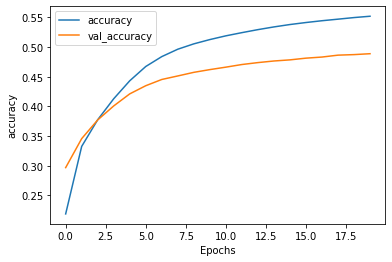

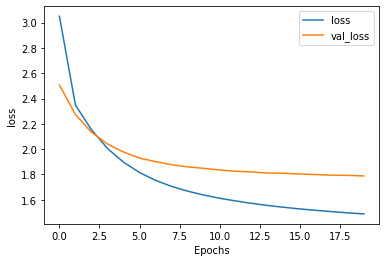

In [ ]:
# 그래프 그리기
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Best model 복원

- validation loss를 기준으로 best 모델만 저장했으므로, 마지막에 저장된 모델이 최종 Best 모델

In [ ]:
print(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

./training_checkpoints/ckpt_20


### 학습된 모델 활용

학습된 모델을 이용하여 텍스트를 생성하려고 함

* 시작 문자열 선택과 순환 신경망 상태를 초기화하고 생성할 문자 수를 설정

* 시작 문자열과 순환 신경망 상태를 사용하여 다음 문자를 예측

* 다음, `tf.random.categorical`을 사용하여 output logit값을 바탕으로 랜덤 샘플링

* 이 예측된 문자를 모델의 다음 입력으로 활용

* 하나의 token을 계속 추가하는 방식으로 autoregressive 하게 샘플링하는 방법을 사용함

* 이를 통해, 길이가 긴 text를 생성하는 것도 가능함

![텍스트를 생성하기 위해 모델의 출력이 입력으로 피드백](https://tensorflow.org/tutorials/text/images/text_generation_sampling.png)

- 생성된 텍스트를 보면 모델이 언제 대문자로 나타나고, 절을 만들고 셰익스피어와 유사한 어휘를 가져오는지 알 수 있음
- 그러나 훈련 Epoch이 적은 관계로 논리적인 문장을 형성하는 것은 훈련되지 않음

In [ ]:
def generate_text(model, start_string, temperature=1.0):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 생성할 문자의 수
  num_generate = 1000

  # 시작 문자열을 숫자로 변환(벡터화)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 온도(temperature)가 낮으면 더 예측 가능한 텍스트가 됩니다.
  # 온도가 높으면 더 의외의 텍스트가 됩니다.
  # 최적의 세팅을 찾기 위한 실험

  # 여기에서 배치 크기 == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 샘플링 (logit 값에 따라 샘플링)
      predictions = predictions / temperature
      # sample된 token들 중 마지막 token만 선택
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 예측된 단어를 다음 입력으로 모델에 전달
      # 이전 은닉 상태와 함께
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string="ROMEO: ", temperature=1.0))

ROMEO: lluth gitouthil s ourit,
teand s theg mor hol, be mmenck fol tew hanovesthar he o?
TETET:

Ff it yand
Le,
whe
OLA.
MENune o, arn merve;
APat thathetoxugrfol:
Best omes ang S:
Buthet phise abll omarfour bI y t,
HAn teat l:
T:
O y plf, who:
We
We hithane s s
bl f the mache f d?
he myechpeyin if n thesco tl ge Vze st:
OLI by, cheadresto miles tck a lis thastHAQAHEThont t, blAncabach holyoullise:
Tharshico ing
When:
O te anat ime;
win begref lene tha yollate touresple 'thed tl'che!

OLove hbarmarin:
Hot Cow uresor thind, tireperphe th Maililu th yist, in kithy gamoupa g sthe wn hithe hell s pes hand amenthoul blle po'Ss,
PED y silaph an As wheTEN VO my mas's bear.
MOLome puris aven:
ETo sthelrckichutomy thenoryZAPe e thag;
Anolyisene mI IKI
Bur ly ane LINu'
INARIS, LAMOYorstourd he LAPa'S o;
S:
qY thee bed sth y:
O:
STe mere:

GAn aneis
Canth y hestolinsther te mifoow a hon, SwI w.
Thy it MI nturely,
AHes:
MO, ny we f ck d; tlomakers, f averethan hend veth here hed, than'toulisth he

- 결과를 개선하는 가장 쉬운 방법은 더 오래 훈련하는 것(ex: `EPOCHS = 30`).
- 이외에 시도해볼 수 있는 것들
  - 다른 시작 문자열
  - RNN 모델 네트워크 구조 수정
  - temperature 조정 
    - 값이 작으면, 예측된 logit 값이 큰 token이 주로 샘플링 
    - 값이 크면, 예측된 logit 값이 작은 token도 샘플링 될 확률이 높아짐

- 다음 문제 실습을 위해, 학습된 모델 삭제

In [ ]:
del model

## RNN 실습
데이터셋은 그대로 이용하고 나머지 부분을 직접 구현해보기

### 문제 1: RNN 모델 만들기
- 조건: 딥러닝 모델의 각 layer는 1번부터 5번까지 순서대로 구성
1. embedding layer, input_dim: vocab size, output_dim: 256
2. LSTM layer, hidden units 512
3. layer normalization
4. dense layer, hidden node: 256, activation ReLU
5. dense layer, hidden node: vocab size
- 딥러닝 모델을 만드는 두가지 방식(tf.keras.Model, tf.keras.models.Sequential) 중 선택하여 만들기

In [ ]:
# 여기에 문제 1에 대한 코드를 작성하면 됩니다.
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)

# 임베딩 차원
embedding_dim = 256

# RNN 유닛(unit) 개수
rnn_units = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(vocab_size)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         1574912   
_________________________________________________________________
layer_normalization_1 (Layer (None, None, 512)         1024      
_________________________________________________________________
dense_3 (Dense)              (None, None, 256)         131328    
_________________________________________________________________
dense_4 (Dense)              (None, None, 65)          16705     
Total params: 1,740,609
Trainable params: 1,740,609
Non-trainable params: 0
_________________________________________________________________


###옵티마이저(optimizer), 손실 함수, 평가 metric 선택
- 기존과 동일함

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### 모델 학습 및 평가
- 체크포인트를 저장하는 checkpoint_dir 및 전체 epoch 수를 제외하고, 기존과 동일함

In [ ]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './checkpoints'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# model.fit 메소드에 함께 이용할 callback 
# 'val_loss'를 monitor하면서, 가장 val_loss가 작을때만 모델을 저장함 (save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, 
    save_weights_only=True, 
    monitor='val_loss',
    save_best_only=True)

# 학습 시간을 위해 10 epoch만 학습
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint_callback])

Epoch 1/10
131/131 [==============================] - 6s 46ms/step - loss: 2.3617 - accuracy: 0.3411 - val_loss: 2.1067 - val_accuracy: 0.3870
Epoch 2/10
131/131 [==============================] - 6s 43ms/step - loss: 1.8658 - accuracy: 0.4526 - val_loss: 1.9555 - val_accuracy: 0.4298
Epoch 3/10
131/131 [==============================] - 6s 43ms/step - loss: 1.6955 - accuracy: 0.4959 - val_loss: 1.8836 - val_accuracy: 0.4544
Epoch 4/10
131/131 [==============================] - 6s 43ms/step - loss: 1.5905 - accuracy: 0.5224 - val_loss: 1.8285 - val_accuracy: 0.4723
Epoch 5/10
131/131 [==============================] - 6s 43ms/step - loss: 1.5149 - accuracy: 0.5421 - val_loss: 1.7884 - val_accuracy: 0.4860
Epoch 6/10
131/131 [==============================] - 6s 43ms/step - loss: 1.4581 - accuracy: 0.5567 - val_loss: 1.7649 - val_accuracy: 0.4955
Epoch 7/10
131/131 [==============================] - 6s 43ms/step - loss: 1.4101 - accuracy: 0.5685 - val_loss: 1.7431 - val_accuracy: 0.4990

### 문제 2: 학습된 모델 활용

위에서 정의된 `generate_text` 함수를 이용하여 텍스트를 생성해보기
- 조건1: 학습된 모델중에서 validation loss를 기준으로 best model 이용하기
- 조건2: "JULIET: "을 `start_string`으로 하고, `temperature`를 0.2, 1.0, 100.0으로 바꾸어 가면서 결과를 출력하고, 출력 결과를 비교하기
- 조건3: temperature는 1.0으로 고정하고, `start_string`을 자유롭게 1가지 넣어보기

In [ ]:
# 여기에 문제 2에 대한 코드를 작성하면 됩니다.
print(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

tem_list = [0.2,1.0,100.0]

for i, tem in enumerate(tem_list):
  print('='*15,f'tem: {tem}','='*15)
  print(generate_text(model, start_string="JULIET: ", temperature=tem))

str_list = ['citizen', 'hello', 'world']

for i, string in enumerate(str_list):
  print('='*15,f'string: {string}','='*15)
  print(generate_text(model, start_string=string , temperature=1.0))


./checkpoints/ckpt_8
=============== tem: 0.2 ===============
JULIET: I the toull an t the the the the th amoull tore there an the the the the the the an the an the the th f the the the me the an there me an the there the the the toul the touse amere an the angoullllll the toul the the the there the an the the ame the the the me the thin the the the toul anoul the the the the ange meran the then the the atherere athe toul the thous the there t tous t the the the there the here the an thoulllll the the the an the the tous mere there an the s tharere an an the athe the athouthe an t the the there the the ange ain t there toullllll toullllll thous t there there the he there me the an an there thin the an an the t there there there there the there the the the he the an the toul t the t there me an the t therere an an thous are thous t thous the tore the t t the t toul the t t win an t the an t thererere the the are tous the the the the t the the the the the the there there he the the there